In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
import os
from sklearn import model_selection
from sklearn import utils
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from scipy import ndimage
from gc import collect
import matplotlib.pyplot as plt
from collections import Counter
from seaborn import heatmap


In [4]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [5]:
labels = get_labels('/kaggle/input/labelsssss/labels.csv')
numbers_per_class = [0, 0, 0, 0]
for i in labels:
    numbers_per_class[np.argmax(labels[i])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 2) for number_of_class in numbers_per_class]
proportion_per_class

[0.35, 0.25, 0.23, 0.17]

In [6]:
path = '/kaggle/input/192x256xdepth/'
dirs = os.listdir(path)

X = [path + i for i in os.listdir(path)]
y = [np.argmax(labels[(path+i)[-14:-4]]) for i in os.listdir(path)]

In [7]:
def balancing_batch(X, y, max_value):
    numbers_per_class = sorted(Counter(y).items())
    
    if len(numbers_per_class) == 1:
        return X[0:1], y[0:1] #return only the first image because the batch has only one class
    
    if numbers_per_class[0][1] > numbers_per_class[1][1]:
        max_per_class = numbers_per_class[1][1]
    else:
        max_per_class = numbers_per_class[0][1]
    
    if max_per_class > max_value//2:
        max_per_class = max_value//2
        
    X, y = utils.shuffle(X, y)
    new_X, new_y = [], []
    counter_class_zero = 0
    counter_class_one = 0
    for test_x, test_y in zip(X, y):
        if test_y == 0 and counter_class_zero < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_zero += 1
        elif test_y == 1 and counter_class_one < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_one += 1
    
    return np.array(new_X, dtype='float16'), np.array(new_y, dtype='float16')

In [8]:
def separate_slices(img):
    'function to separate 2d images of 3d original image'
    slices = []

    for i in range(img.shape[-2]):
        slices.append(np.array(img[:, :, i]))

    slices.append(np.mean(img, axis=-2)) #including mean of slices
        
    return slices

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y,random_state=42, train_size=0.8)

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, objective, list_IDs, labels_dir, batch_size, sub_batch_size, dim_img, training, shuffle=True):
        self.objective = objective # list representing one hot encoding for choice label ([1, 0, 0, 0] for normal, [0, 0, 0, 1] for cancer ..)
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.labels = self.__get_labels(labels_dir) #dict with labels of all images
        self.batch_size = batch_size #3d-images per batch
        self.sub_batch_size = sub_batch_size #quantity of sub-images per batch will be choose to train
        self.dim_img = dim_img # tuple with width and height of image like (192, 256)
        self.training = training # true if generator is for training, false if generator is for validation
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function
        
    
    def __get_labels(self, label_file):
        'take the dict with labels of images'
        labels = pd.read_csv(label_file)
        cancer_labels = dict()

        for p in labels.index:
            cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

        return cancer_labels
    
    def __data_augmentation(self, x):
        'generate variations of images'
        new_images = []
        x = x.astype('float16')
        new_images.append(x)
        
        x = cv2.flip(x.astype('float32'), 1).astype('float16')
            
        new_images.append(np.expand_dims(x, -1))

        return utils.shuffle(new_images)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    

    def __getitem__(self, index):        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        if self.training:
            X, y = balancing_batch(X, y, self.sub_batch_size)
            return np.array(X[0:self.sub_batch_size], dtype='float16'), np.array(y[0:self.sub_batch_size], dtype='uint8')
        
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            prev_len_X = len(X)
            full_image = np.load(ID)
            new_images = separate_slices(full_image)
            if self.training:
                for img in new_images:
                    X += self.__data_augmentation(img)
            else:
                X = np.array(new_images, dtype='float16')
            
            #adding new data labels for y array
            for _ in range(len(X) - prev_len_X):
                if self.labels[ID[-14:-4]] == self.objective: #'-14:-4 represent a part of string with name of original image that slices was taken'
                    y.append(1)
                else:
                    y.append(0)
                    
        X, y = utils.shuffle(X, y)
        return X, y

In [11]:
class SE_ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

        self.SE = [keras.layers.GlobalAvgPool2D(),
                   keras.layers.Flatten(),
                   keras.layers.Dense(filters//4, activation='relu'),
                   keras.layers.Dense(filters, activation='sigmoid'),
                   keras.layers.Reshape([1,1,filters])]

        self.block_layers = [keras.layers.Conv2D(filters, kernel_size=(3,4), strides=strides, padding='same', use_bias=False),
                             keras.layers.BatchNormalization(),
                             self.activation,
                             keras.layers.Conv2D(filters, kernel_size=(3,4), strides=1, padding='same', use_bias=False),
                             keras.layers.BatchNormalization()]
        
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [keras.layers.Conv2D(filters, kernel_size=(1,1), strides=strides, padding='same', use_bias=False),
                                keras.layers.BatchNormalization()]

    def call(self, x):
        inputs = tf.identity(x)
        x1 = tf.identity(x)
        
        for layer in self.block_layers:
            x1 = layer(x1)

        x2 = tf.identity(x1)
        for layer in self.SE:
            x2 = layer(x2)
        
        prod_calibration = x1*x2
        
        for layer in self.skip_layers:
            inputs = layer(inputs)
        
        
        return self.activation(prod_calibration + inputs)

def get_SE_resnet34():
    resnet34 = keras.models.Sequential()
    resnet34.add(keras.layers.Conv2D(filters=64, kernel_size=(7,9), strides=2, padding='same', use_bias=False, input_shape=(192, 256, 1)))
    resnet34.add(keras.layers.BatchNormalization())
    resnet34.add(keras.layers.Activation(keras.activations.relu))
    resnet34.add(keras.layers.MaxPool2D(pool_size=(3,4), strides=2, padding='same'))

    prev_filters = 64
    for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
        if filters == prev_filters :
            strides = 1
        else:
            strides = 2

        resnet34.add(SE_ResidualUnit(filters, strides))
        prev_filters = filters

    resnet34.add(keras.layers.GlobalAvgPool2D())
    resnet34.add(keras.layers.Flatten())
    resnet34.add(keras.layers.Dense(units=1, activation='sigmoid'))

    return resnet34

**NORMAL**

In [14]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [15]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[1, 0, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    resnet = get_SE_resnet34()
    
    resnet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(resnet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 140s 3s/step - loss: 0.8565 - AUC_1: 0.4774 - accuracy: 0.5045 - precision: 0.5041 - recall: 0.5027 - val_loss: 0.6914 - val_AUC_1: 0.4562 - val_accuracy: 0.7081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 68s 2s/step - loss: 0.7328 - AUC_1: 0.5507 - accuracy: 0.5062 - precision: 0.5083 - recall: 0.3591 - val_loss: 0.7760 - val_AUC_1: 0.5981 - val_accuracy: 0.2919 - val_precision: 0.2919 - val_recall: 1.0000 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 72s 2s/step - loss: 0.6602 - AUC_1: 0.6849 - accuracy: 0.6152 - precision: 0.6619 - recall: 0.4699 - val_loss: 0.7822 - val_AUC_1: 0.4816 - val_accuracy: 0.2919 - val_precision: 0.2919 - val_recall: 1.0000 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 73s 2s/step - loss: 0.5972 - AUC_1: 0.7467 - accuracy: 0.6973 - precision: 0.6881 - recall: 0.7218 - va

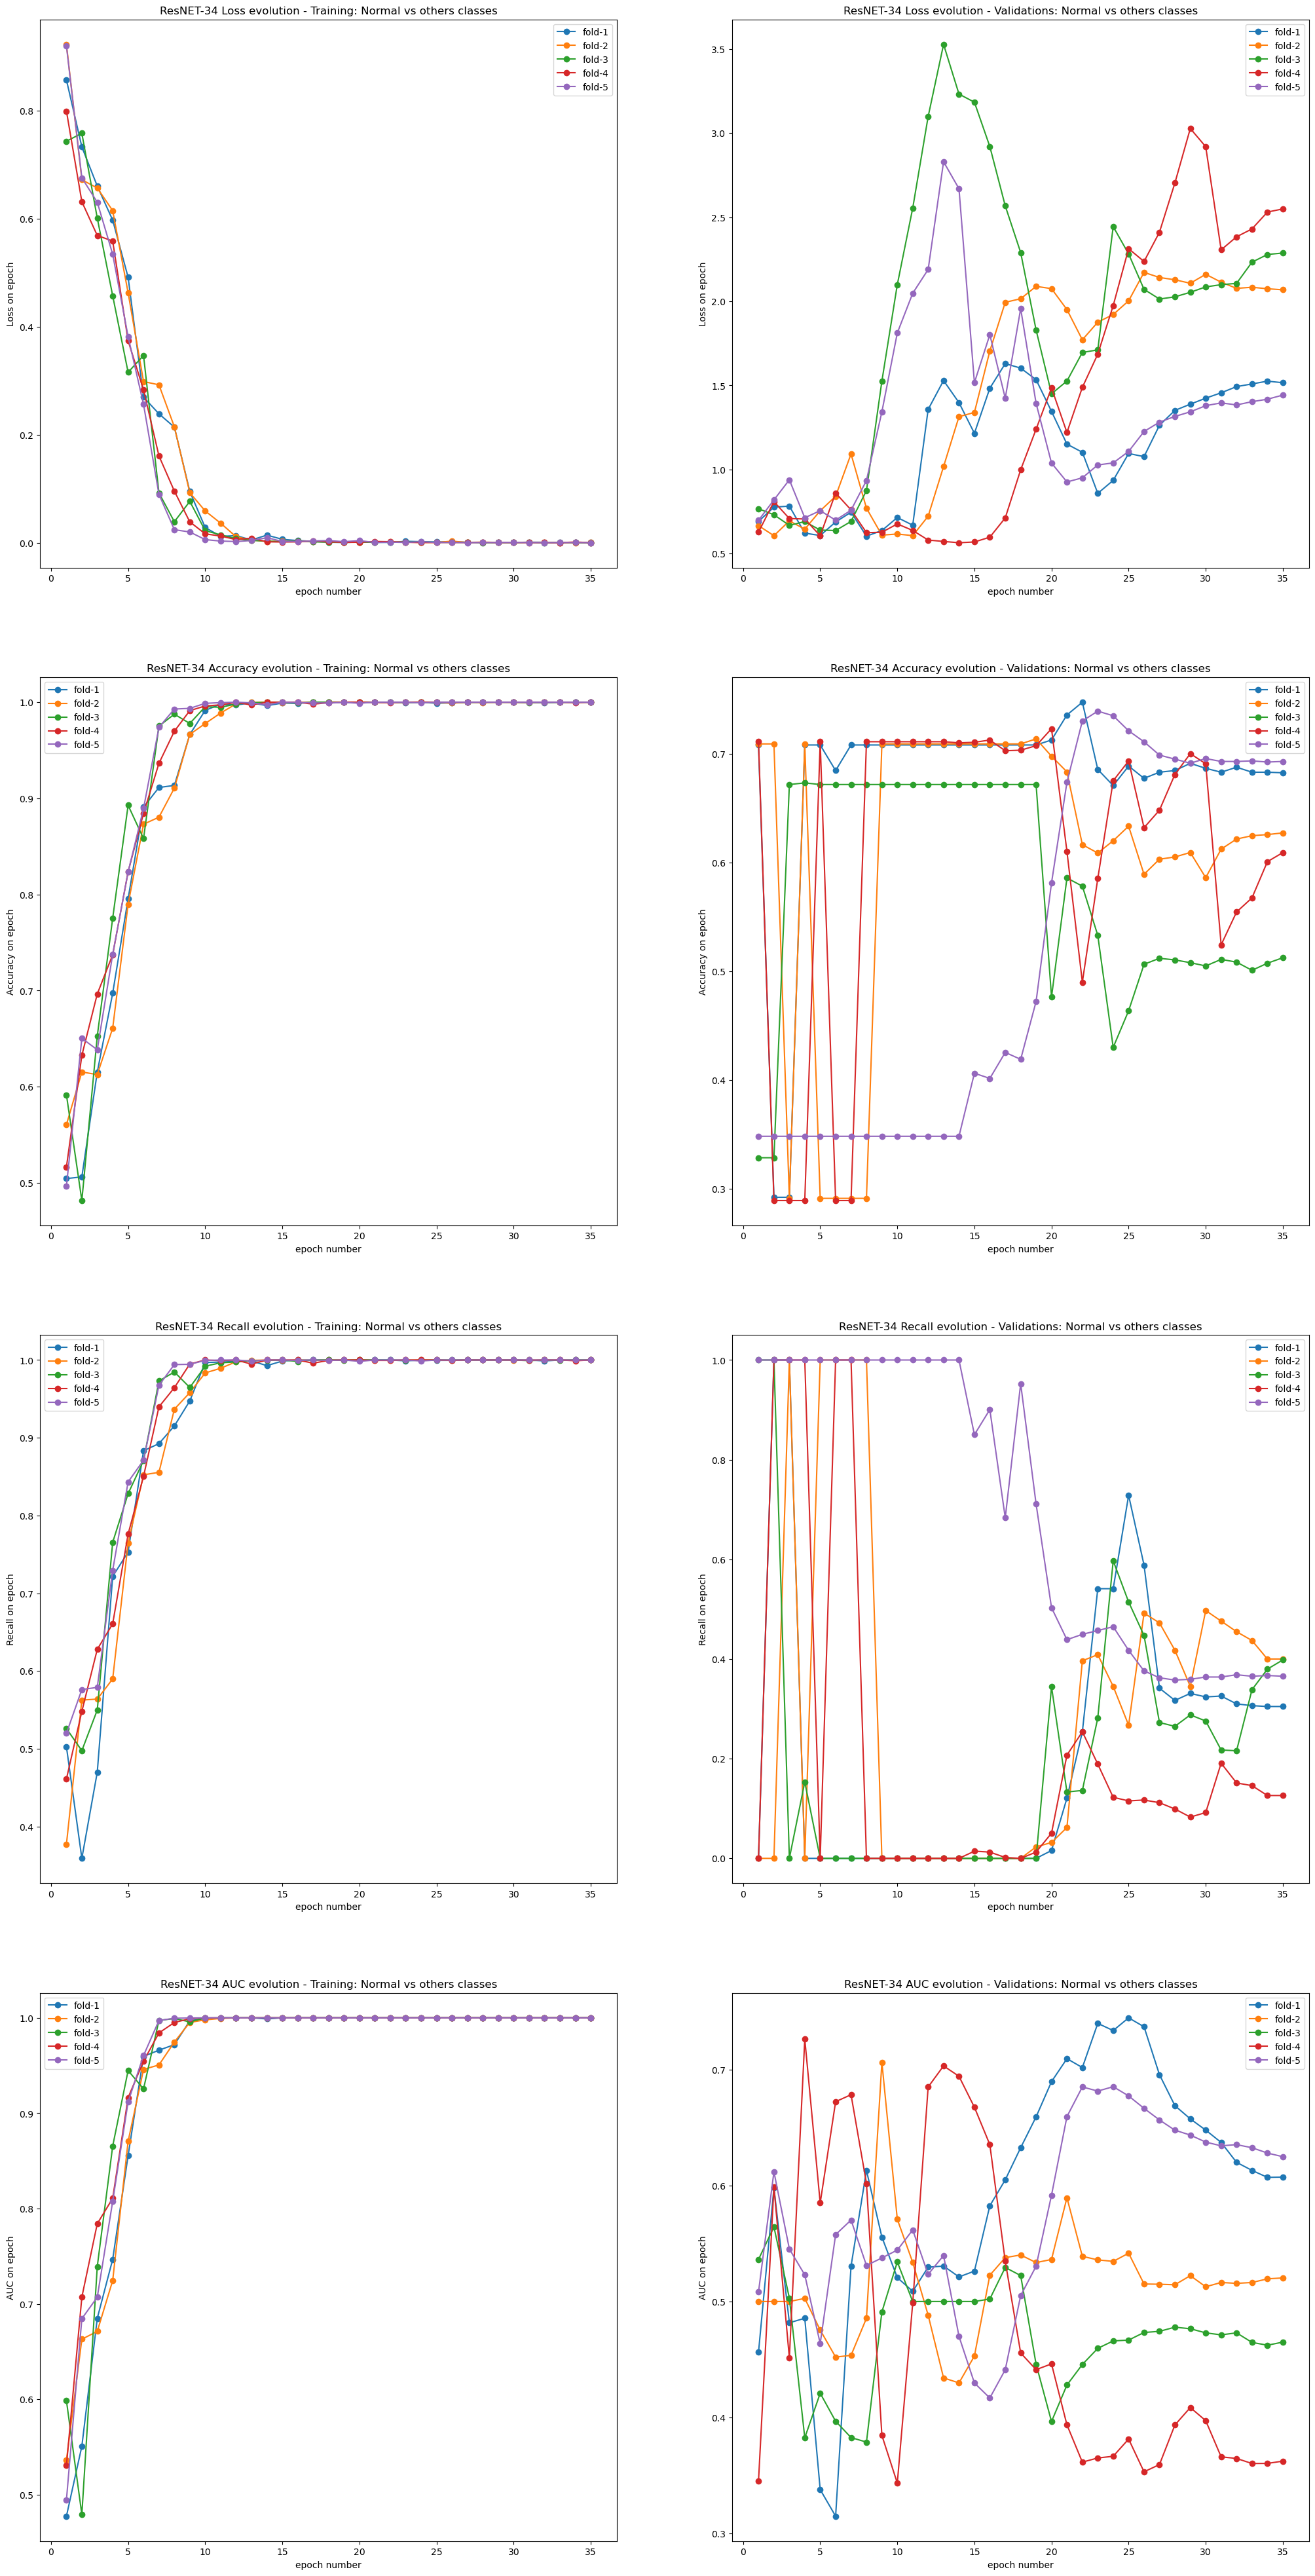

In [16]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('ResNET-34 Loss evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('ResNET-34 Loss evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('ResNET-34 Accuracy evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('ResNET-34 Accuracy evolution - Validations: Normal vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('ResNET-34 Recall evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('ResNET-34 Recall evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('ResNET-34 AUC evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('ResNET-34 AUC evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [17]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.7448064088821411
Best Accuracy in validation: 0.7474437355995178
Best Precision in validation: 1.0
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.7064472436904907
Best Accuracy in validation: 0.7136971950531006
Best Precision in validation: 0.7647058963775635
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5643712282180786
Best Accuracy in validation: 0.673202633857727
Best Precision in validation: 0.5076141

**ACTIONABLE**

In [18]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [19]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 1, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    resnet = get_SE_resnet34()
    
    resnet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(resnet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 81s 1s/step - loss: 0.7931 - AUC_1: 0.5194 - accuracy: 0.4836 - precision: 0.4760 - recall: 0.3418 - val_loss: 0.6606 - val_AUC_1: 0.4950 - val_accuracy: 0.8047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 69s 2s/step - loss: 0.7675 - AUC_1: 0.6318 - accuracy: 0.5820 - precision: 0.6443 - recall: 0.3614 - val_loss: 0.6397 - val_AUC_1: 0.5473 - val_accuracy: 0.8047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 72s 2s/step - loss: 0.5225 - AUC_1: 0.8431 - accuracy: 0.7712 - precision: 0.8433 - recall: 0.6651 - val_loss: 0.5040 - val_AUC_1: 0.5000 - val_accuracy: 0.8047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 66s 2s/step - loss: 0.3711 - AUC_1: 0.9187 - accuracy: 0.8388 - precision: 0.8556 - reca

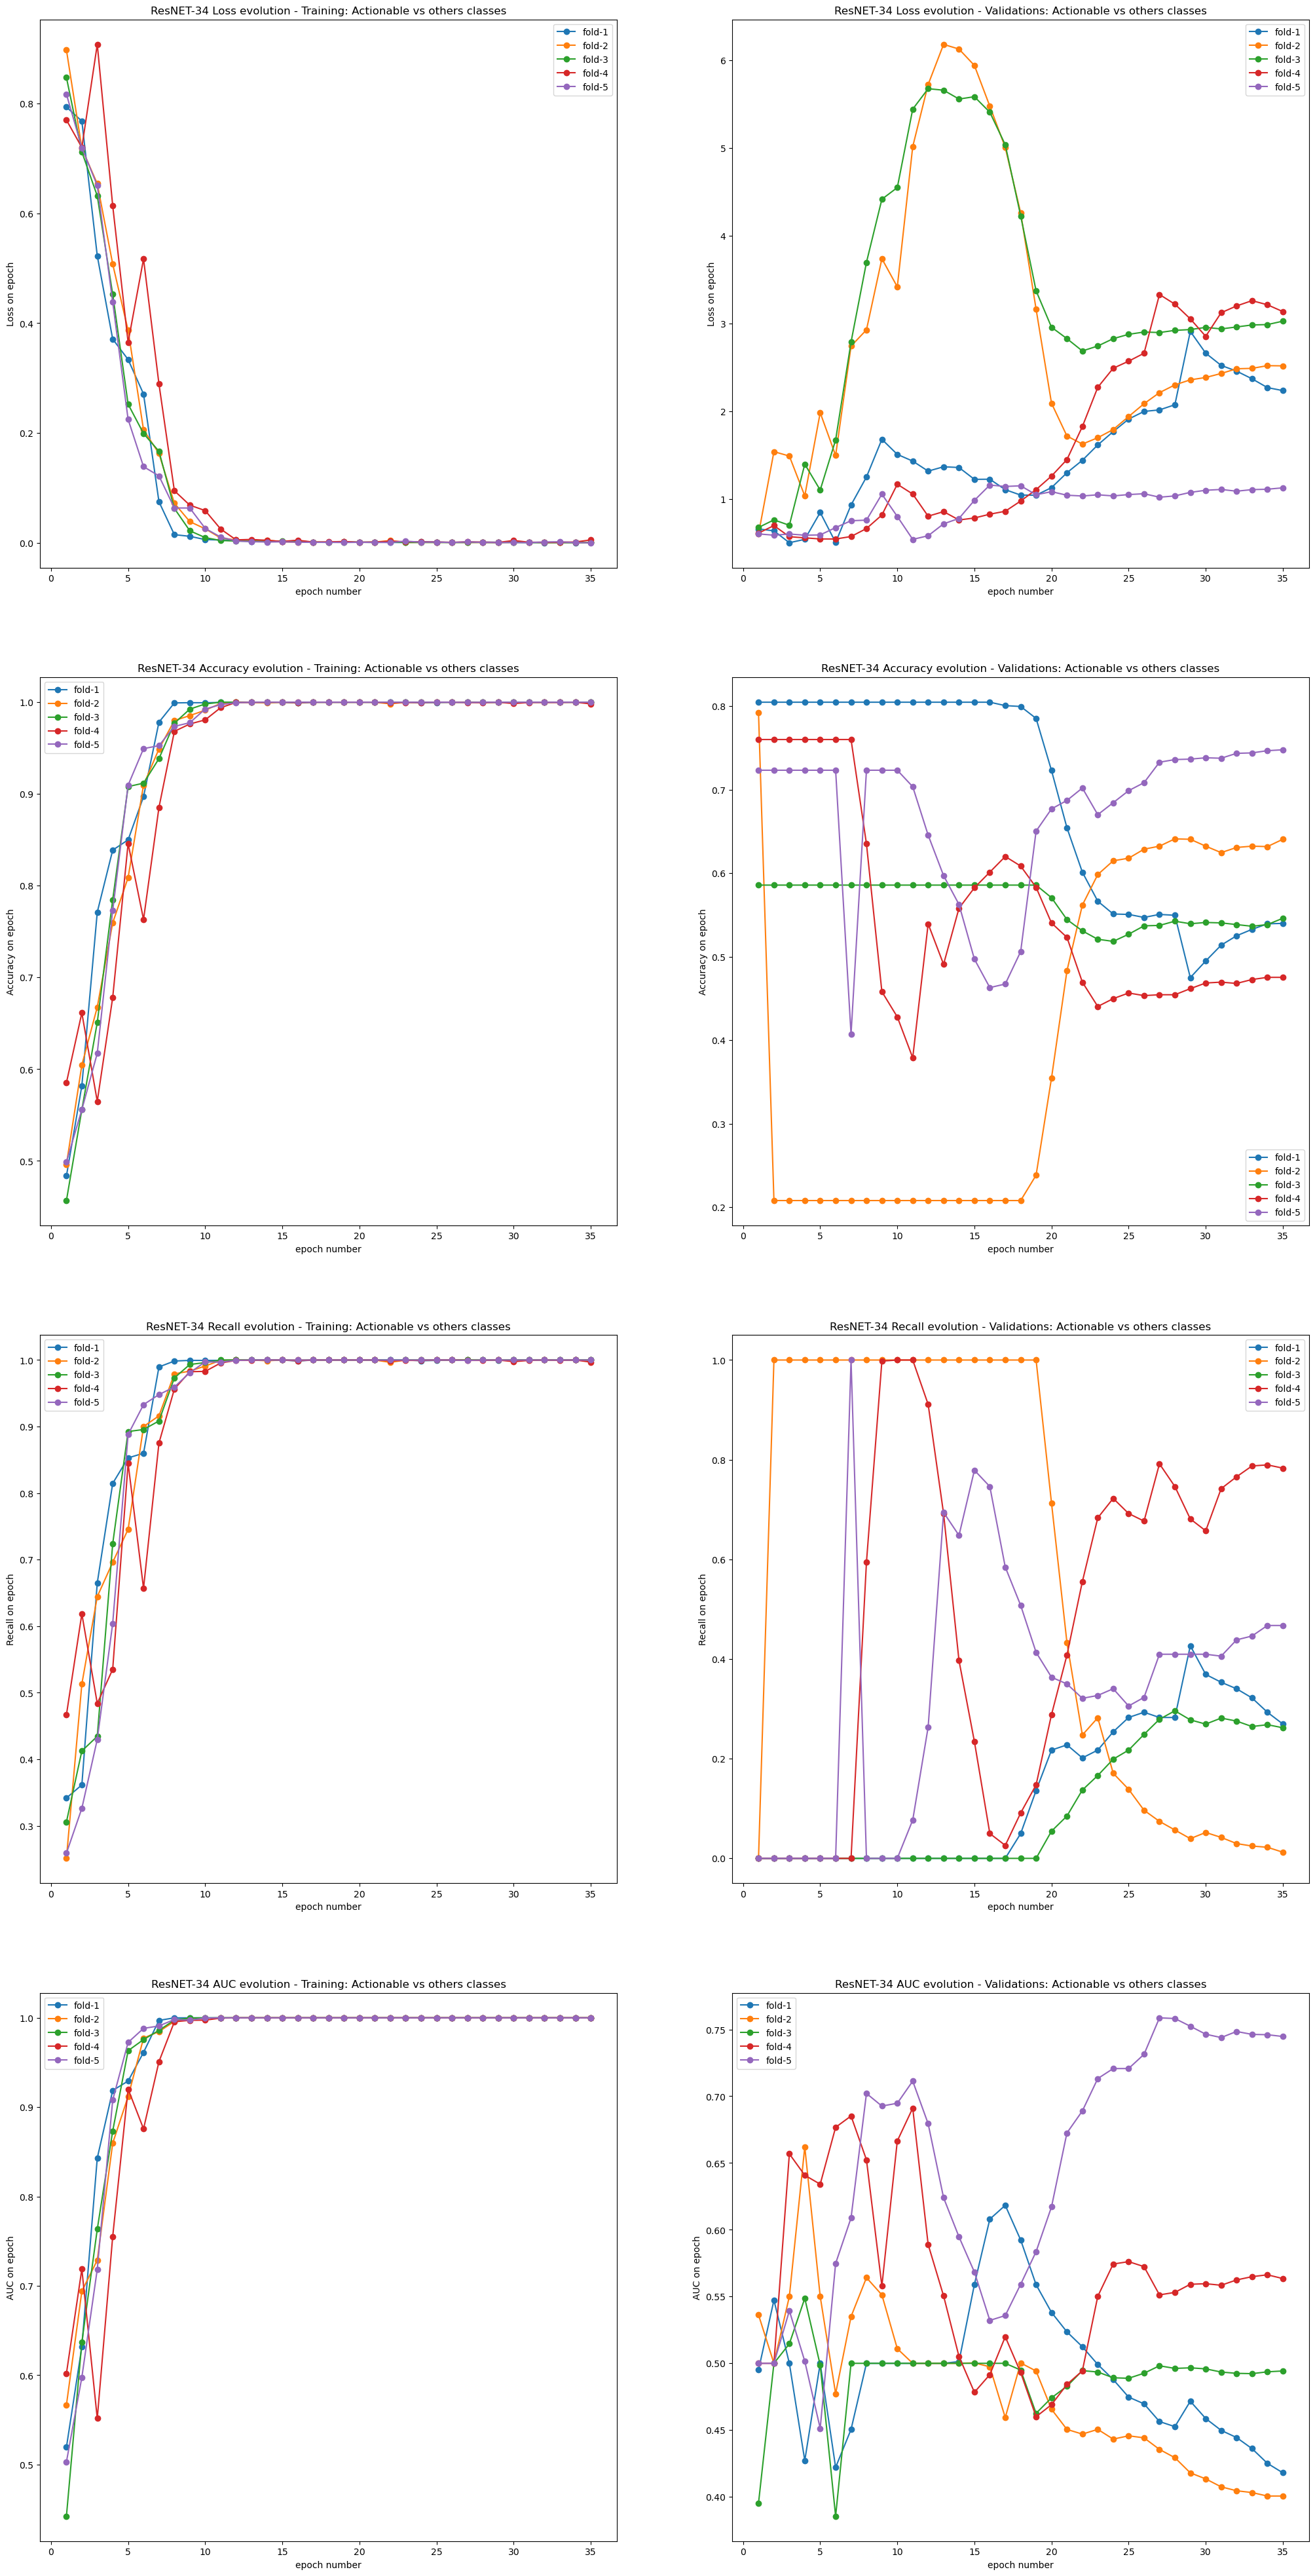

In [20]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('ResNET-34 Loss evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('ResNET-34 Loss evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('ResNET-34 Accuracy evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('ResNET-34 Accuracy evolution - Validations: Actionable vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('ResNET-34 Recall evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('ResNET-34 Recall evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('ResNET-34 AUC evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('ResNET-34 AUC evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [22]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.618312418460846
Best Accuracy in validation: 0.8047034740447998
Best Precision in validation: 0.3958333432674408
Best Recall in validation: 0.4267015755176544


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6621303558349609
Best Accuracy in validation: 0.7919670343399048
Best Precision in validation: 0.21455125510692596
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5487072467803955
Best Accuracy in validation: 0.585721492767334
Best Precision in valida

**BENIGN**

In [12]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [13]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 1, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    resnet = get_SE_resnet34()
    
    resnet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(resnet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 123s 3s/step - loss: 0.9876 - AUC_1: 0.5744 - accuracy: 0.5647 - precision: 0.5807 - recall: 0.4569 - val_loss: 0.6849 - val_AUC_1: 0.5085 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 69s 2s/step - loss: 0.7816 - AUC_1: 0.6197 - accuracy: 0.5263 - precision: 0.5450 - recall: 0.3027 - val_loss: 0.6856 - val_AUC_1: 0.5263 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 68s 2s/step - loss: 0.8182 - AUC_1: 0.6380 - accuracy: 0.5455 - precision: 0.5687 - recall: 0.3642 - val_loss: 0.7329 - val_AUC_1: 0.5098 - val_accuracy: 0.3947 - val_precision: 0.3947 - val_recall: 1.0000 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 64s 2s/step - loss: 0.8337 - AUC_1: 0.5091 - accuracy: 0.5394 - precision: 0.5737 - recall: 0.2

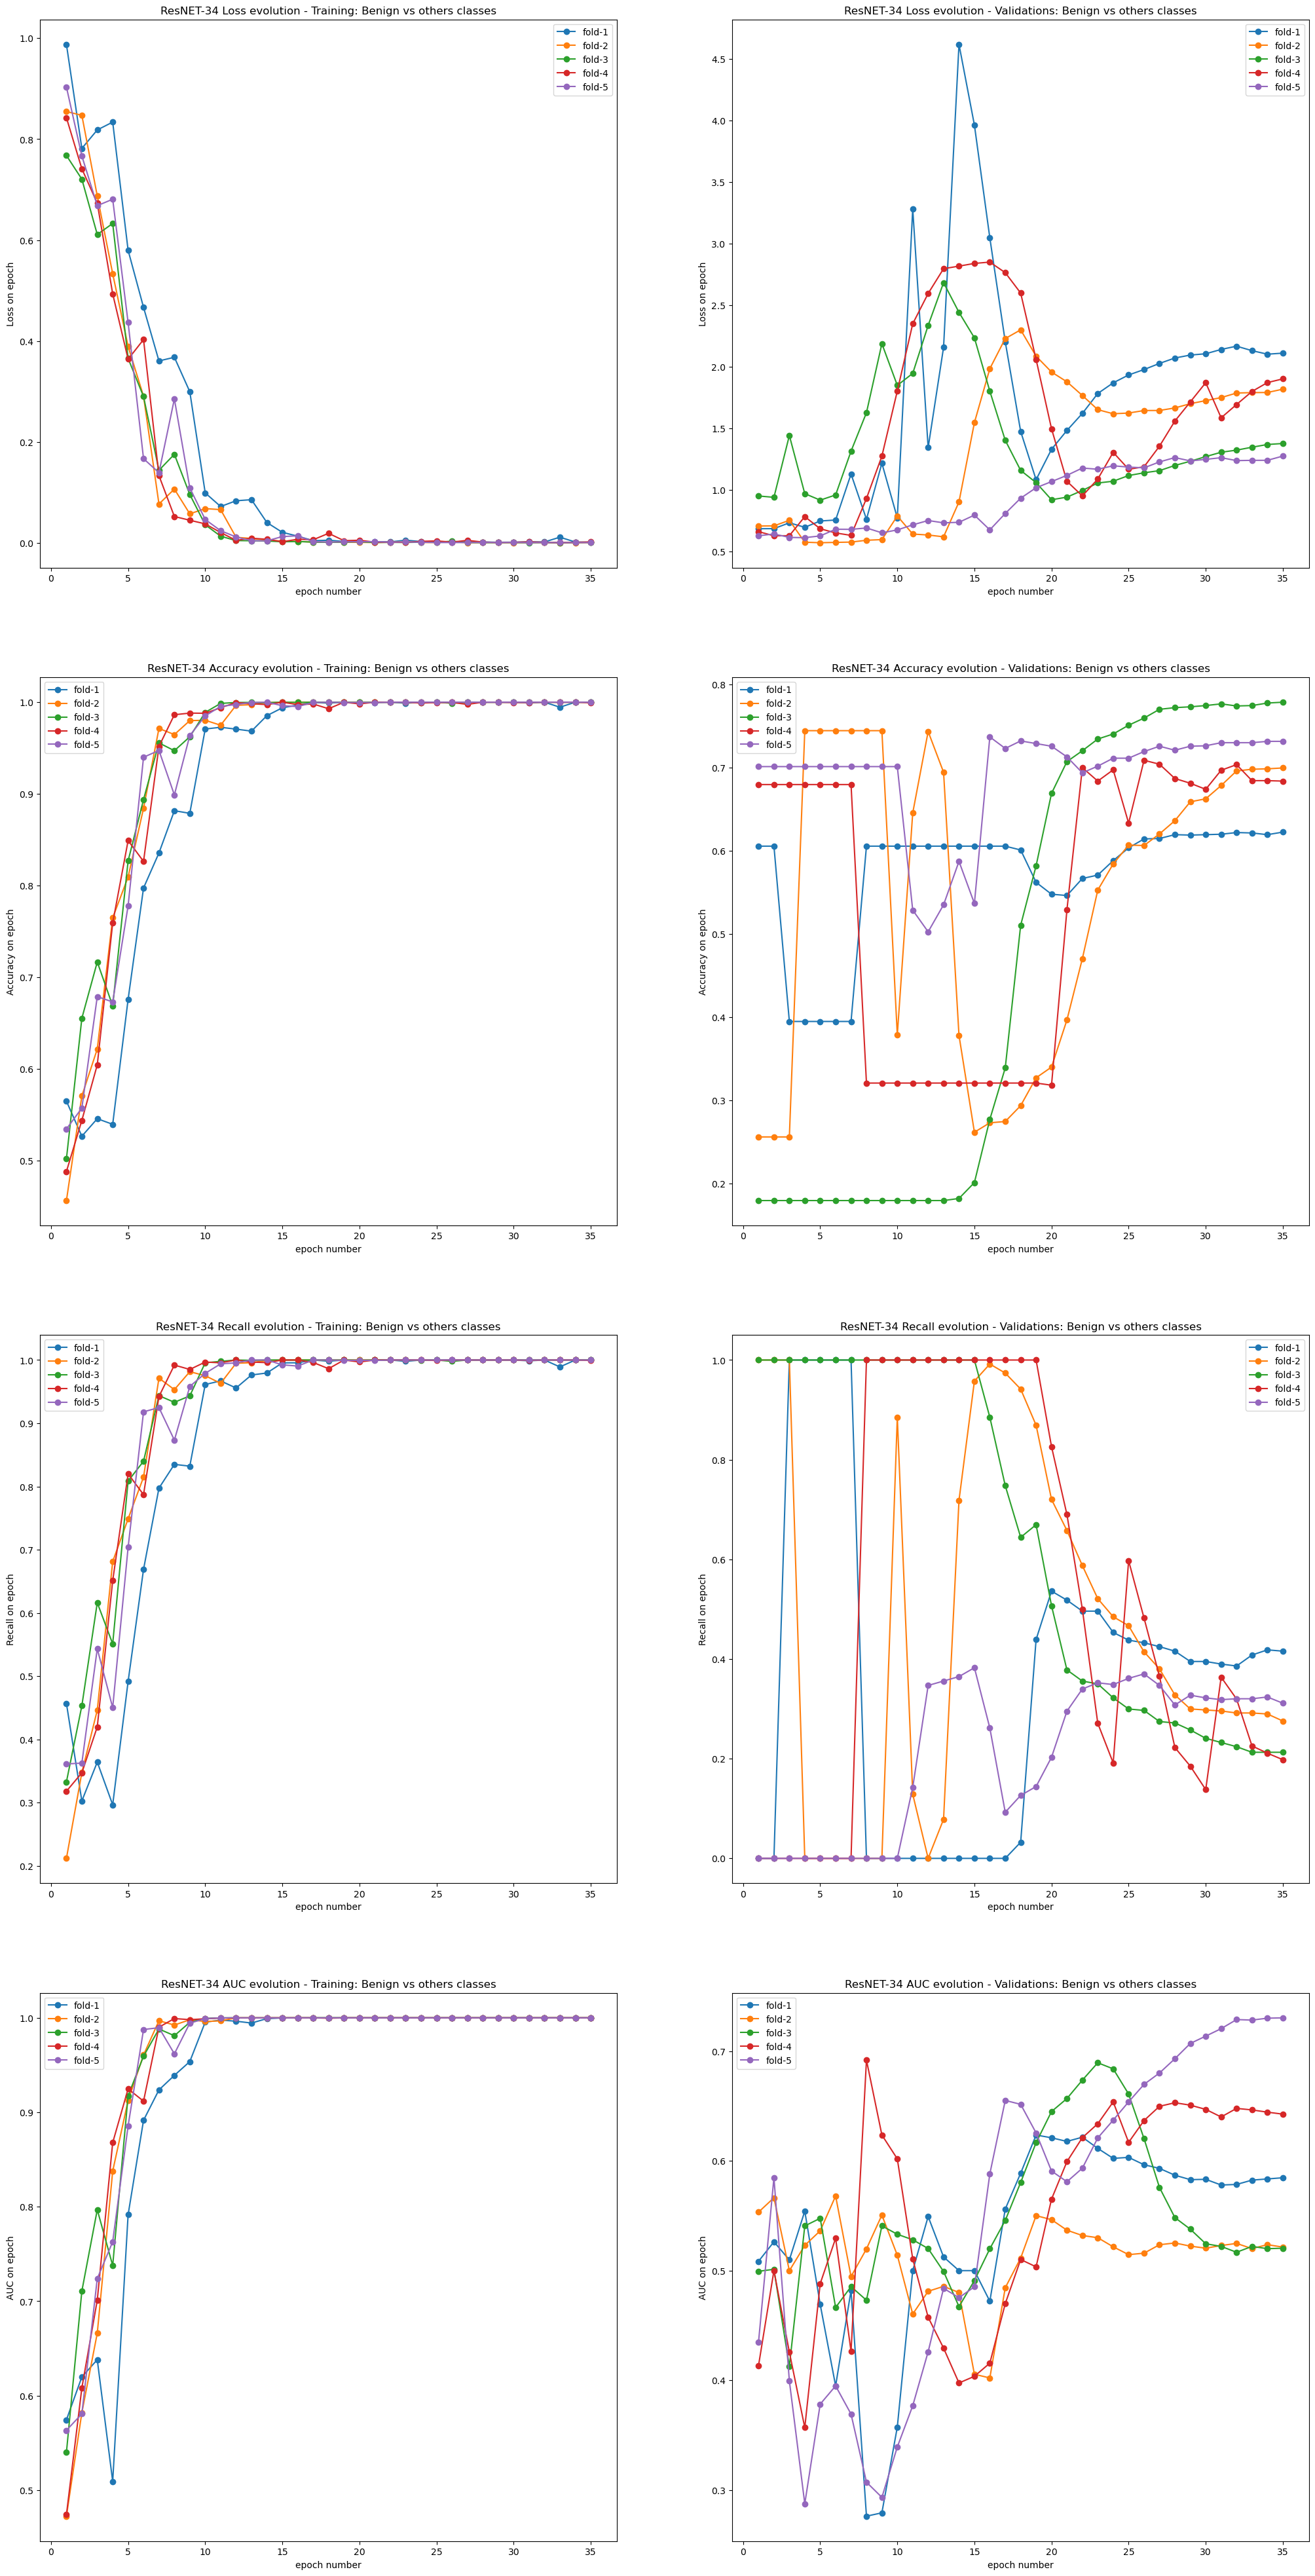

In [14]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('ResNET-34 Loss evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('ResNET-34 Loss evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('ResNET-34 Accuracy evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('ResNET-34 Accuracy evolution - Validations: Benign vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('ResNET-34 Recall evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('ResNET-34 Recall evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('ResNET-34 AUC evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('ResNET-34 AUC evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [15]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6235668063163757
Best Accuracy in validation: 0.622188150882721
Best Precision in validation: 0.5283687710762024
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5680268406867981
Best Accuracy in validation: 0.7440782785415649
Best Precision in validation: 0.3819628655910492
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6894162893295288
Best Accuracy in validation: 0.7782805562019348
Best Prec

**CANCER**

In [16]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [17]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 0, 1],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    resnet = get_SE_resnet34()
    
    resnet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(resnet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 78s 1s/step - loss: 0.9360 - AUC_1: 0.4813 - accuracy: 0.4572 - precision: 0.2552 - recall: 0.0477 - val_loss: 0.5848 - val_AUC_1: 0.4812 - val_accuracy: 0.8819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 58s 2s/step - loss: 0.8437 - AUC_1: 0.6888 - accuracy: 0.5665 - precision: 0.6961 - recall: 0.2276 - val_loss: 0.4073 - val_AUC_1: 0.3945 - val_accuracy: 0.8819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 56s 2s/step - loss: 0.7618 - AUC_1: 0.7001 - accuracy: 0.5699 - precision: 0.6583 - recall: 0.2802 - val_loss: 0.5438 - val_AUC_1: 0.4594 - val_accuracy: 0.8819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 60s 2s/step - loss: 0.5147 - AUC_1: 0.8816 - accuracy: 0.7395 - precision: 0.8545 - reca

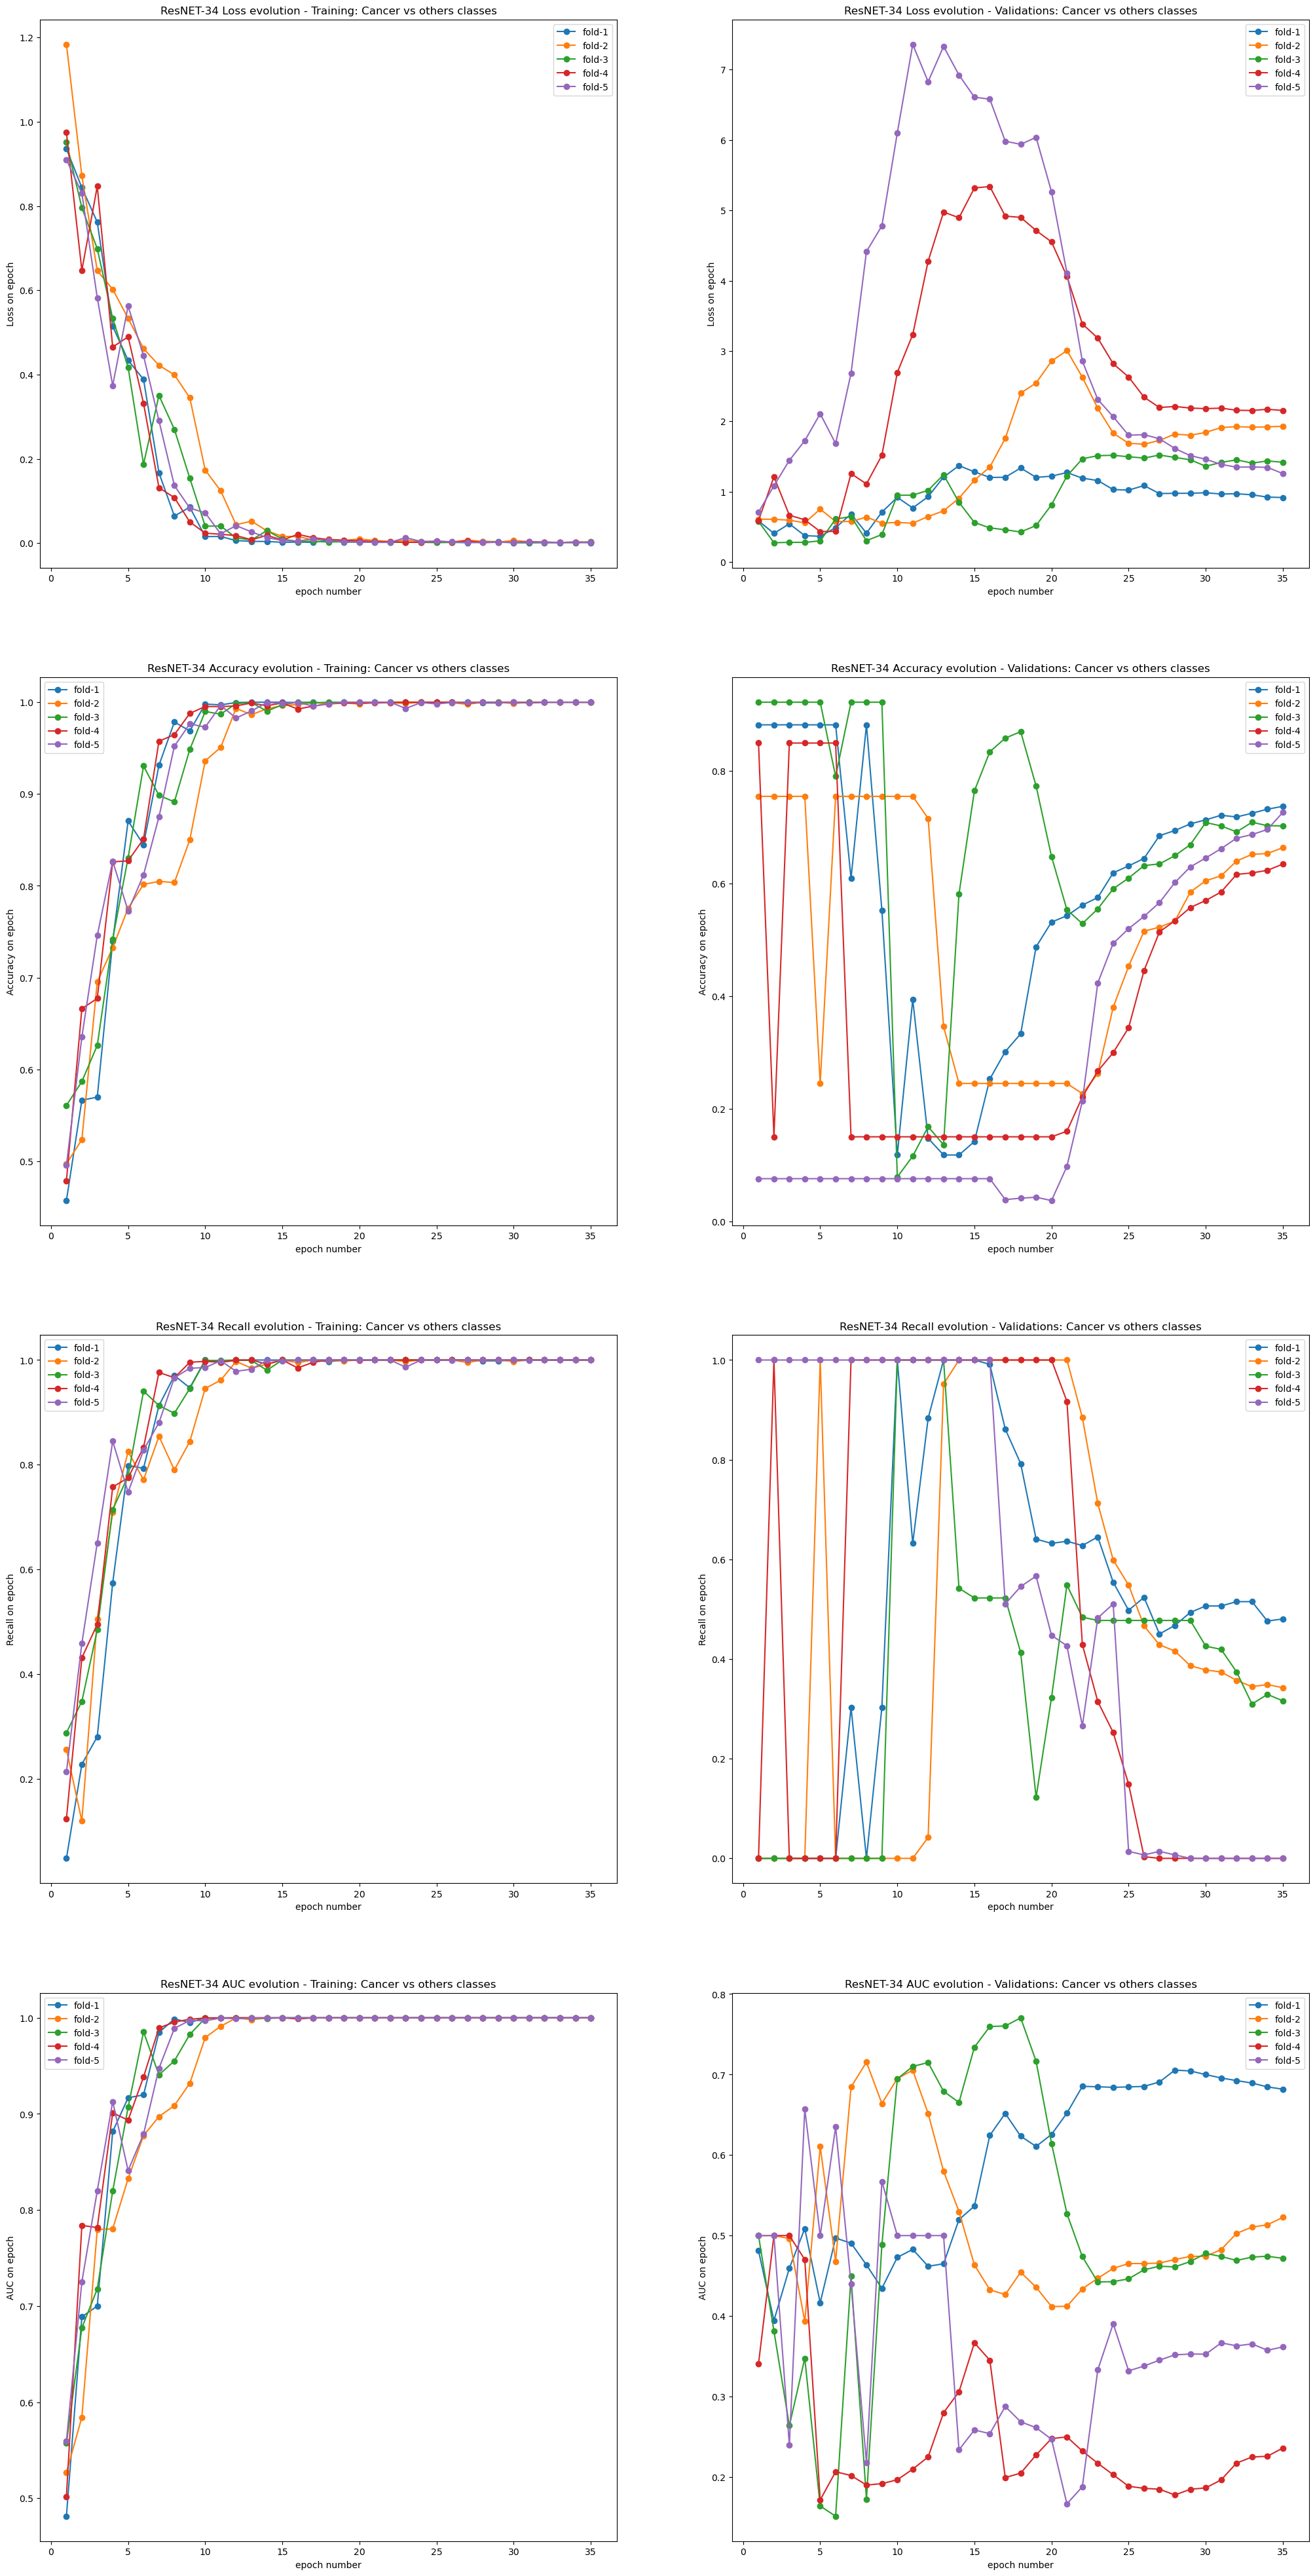

In [18]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('ResNET-34 Loss evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('ResNET-34 Loss evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('ResNET-34 Accuracy evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('ResNET-34 Accuracy evolution - Validations: Cancer vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('ResNET-34 Recall evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('ResNET-34 Recall evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('ResNET-34 AUC evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('ResNET-34 AUC evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [19]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.7055373787879944
Best Accuracy in validation: 0.8819018602371216
Best Precision in validation: 0.21980197727680206
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.7153705358505249
Best Accuracy in validation: 0.7548918724060059
Best Precision in validation: 0.32405567169189453
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.7704329490661621
Best Accuracy in validation: 0.9220713973045349
Best Precision in validation: 0.2802

**TESTS**

NORMAL VS OTHERS

In [20]:
training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
resnet = get_SE_resnet34()    
    
resnet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
resnet.load_weights('/kaggle/working/models/normal_auc1/') #start with best AUC in validations
history = resnet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 92s 2s/step - loss: 0.4212 - AUC: 0.9493 - accuracy: 0.8930 - precision: 0.9023 - recall: 0.8814
Epoch 2/10
35/35 [==============================] - 60s 2s/step - loss: 0.1606 - AUC: 0.9837 - accuracy: 0.9468 - precision: 0.9361 - recall: 0.9590
Epoch 3/10
35/35 [==============================] - 54s 2s/step - loss: 0.0640 - AUC: 0.9976 - accuracy: 0.9773 - precision: 0.9770 - recall: 0.9777
Epoch 4/10
35/35 [==============================] - 53s 2s/step - loss: 0.0747 - AUC: 0.9956 - accuracy: 0.9752 - precision: 0.9780 - recall: 0.9723
Epoch 5/10
35/35 [==============================] - 42s 1s/step - loss: 0.0274 - AUC: 0.9998 - accuracy: 0.9927 - precision: 0.9967 - recall: 0.9886
Epoch 6/10
35/35 [==============================] - 44s 1s/step - loss: 0.0205 - AUC: 0.9997 - accuracy: 0.9946 - precision: 0.9965 - recall: 0.9927
Epoch 7/10
35/35 [==============================] - 43s 1s/step - loss: 0.0117 - AUC: 1.0000 - accuracy: 0

In [21]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = resnet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [22]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 0:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[18  8]
 [11  8]]
0.5777777777777777


ACTIONABLE VS OTHERS

In [23]:
training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
resnet = get_SE_resnet34()    
    
resnet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
resnet.load_weights('/kaggle/working/models/actionable_auc5/') #start with best AUC in validations
history = resnet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 101s 2s/step - loss: 0.5792 - AUC: 0.9298 - accuracy: 0.8777 - precision: 0.9277 - recall: 0.8188
Epoch 2/10
35/35 [==============================] - 65s 2s/step - loss: 0.2589 - AUC: 0.9734 - accuracy: 0.9093 - precision: 0.9459 - recall: 0.8680
Epoch 3/10
35/35 [==============================] - 63s 2s/step - loss: 0.0701 - AUC: 0.9951 - accuracy: 0.9787 - precision: 0.9830 - recall: 0.9743
Epoch 4/10
35/35 [==============================] - 59s 2s/step - loss: 0.0431 - AUC: 0.9990 - accuracy: 0.9831 - precision: 0.9783 - recall: 0.9879
Epoch 5/10
35/35 [==============================] - 59s 2s/step - loss: 0.0554 - AUC: 0.9971 - accuracy: 0.9841 - precision: 0.9906 - recall: 0.9773
Epoch 6/10
35/35 [==============================] - 63s 2s/step - loss: 0.0208 - AUC: 0.9998 - accuracy: 0.9947 - precision: 0.9966 - recall: 0.9928
Epoch 7/10
35/35 [==============================] - 62s 2s/step - loss: 0.0153 - AUC: 1.0000 - accuracy: 

In [24]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = resnet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


In [25]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 1:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[25  9]
 [ 8  3]]
0.6222222222222222


BENIGN VS OTHERS

In [26]:
training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
resnet = get_SE_resnet34()    
    
resnet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
resnet.load_weights('/kaggle/working/models/benign_auc5/') #start with best AUC in validations
history = resnet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 101s 2s/step - loss: 0.5885 - AUC: 0.9329 - accuracy: 0.8629 - precision: 0.9277 - recall: 0.7864
Epoch 2/10
35/35 [==============================] - 63s 2s/step - loss: 0.2127 - AUC: 0.9794 - accuracy: 0.9474 - precision: 0.9815 - recall: 0.9118
Epoch 3/10
35/35 [==============================] - 69s 2s/step - loss: 0.1022 - AUC: 0.9925 - accuracy: 0.9652 - precision: 0.9663 - recall: 0.9638
Epoch 4/10
35/35 [==============================] - 66s 2s/step - loss: 0.1595 - AUC: 0.9884 - accuracy: 0.9444 - precision: 0.9586 - recall: 0.9287
Epoch 5/10
35/35 [==============================] - 65s 2s/step - loss: 0.0477 - AUC: 0.9982 - accuracy: 0.9837 - precision: 0.9789 - recall: 0.9887
Epoch 6/10
35/35 [==============================] - 63s 2s/step - loss: 0.0925 - AUC: 0.9933 - accuracy: 0.9675 - precision: 0.9737 - recall: 0.9609
Epoch 7/10
35/35 [==============================] - 66s 2s/step - loss: 0.0542 - AUC: 0.9982 - accuracy: 

In [27]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = resnet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0]


In [28]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 2:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[27  7]
 [ 7  4]]
0.6888888888888889


CANCER VS OTHERS

In [12]:
training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
resnet = get_SE_resnet34()    
    
resnet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
resnet.load_weights('/kaggle/working/models/cancer_auc3/') #start with best AUC in validations
history = resnet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 121s 2s/step - loss: 0.3699 - AUC: 0.9536 - accuracy: 0.9258 - precision: 0.9778 - recall: 0.8701
Epoch 2/10
35/35 [==============================] - 51s 1s/step - loss: 0.0892 - AUC: 0.9958 - accuracy: 0.9632 - precision: 0.9633 - recall: 0.9625
Epoch 3/10
35/35 [==============================] - 44s 1s/step - loss: 0.0649 - AUC: 0.9971 - accuracy: 0.9788 - precision: 0.9900 - recall: 0.9671
Epoch 4/10
35/35 [==============================] - 44s 1s/step - loss: 0.0436 - AUC: 0.9991 - accuracy: 0.9827 - precision: 0.9737 - recall: 0.9920
Epoch 5/10
35/35 [==============================] - 41s 1s/step - loss: 0.0335 - AUC: 0.9995 - accuracy: 0.9857 - precision: 0.9768 - recall: 0.9948
Epoch 6/10
35/35 [==============================] - 39s 1s/step - loss: 0.0154 - AUC: 1.0000 - accuracy: 0.9958 - precision: 0.9964 - recall: 0.9950
Epoch 7/10
35/35 [==============================] - 38s 1s/step - loss: 0.0052 - AUC: 1.0000 - accuracy: 

In [13]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = resnet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 3:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[35  5]
 [ 4  1]]
0.8
